This is our simple Colab demo notebook, which can run on a CPU instance, though it may crash a regular colab CPU instance since it's memory intensive. If that happens, a message should appear on the bottom left asking if you would like to switch to a 25 gb RAM instance, which will be more than enough memory

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,RepeatedStratifiedKFold,StratifiedKFold
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv('/content/sample_data/cleaned_dataset.csv')

In [ ]:
# # Get training and test sets
# from sklearn.model_selection import train_test_split

# X = df[df.loc[:, df.columns != 'status'].columns]
# y = df['status']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
# X2=X.drop(['name'],axis=1)
# X2.columns


# # grouping by frequency
# fq = X2.groupby('market').size()/len(df)  
# # mapping values to dataframe
# X2.loc[:, "{}_freq_encode".format('market')] = X2['market'].map(fq) 
# # drop original column.
# X2 = X2.drop(['market'], axis = 1)

# fq2 = X2.groupby('country_code').size()/len(df)  
# # mapping values to dataframe
# X2.loc[:, "{}_freq_encode".format('country_code')] = X2['country_code'].map(fq2) 
# # drop original column.
# X2 = X2.drop(['country_code'], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  33147 non-null  object 
 1   market                33147 non-null  object 
 2   status                33147 non-null  object 
 3   country_code          33147 non-null  object 
 4   funding_rounds        33147 non-null  float64
 5   founded_month         33147 non-null  float64
 6   founded_quarter       33147 non-null  float64
 7   founded_year          33147 non-null  float64
 8   seed                  33147 non-null  float64
 9   venture               33147 non-null  float64
 10  equity_crowdfunding   33147 non-null  float64
 11  undisclosed           33147 non-null  float64
 12  convertible_note      33147 non-null  float64
 13  debt_financing        33147 non-null  float64
 14  angel                 33147 non-null  float64
 15  grant              

In [ ]:
df['total_investment'] = df['seed'] + df['venture'] +df['equity_crowdfunding'] + df['undisclosed'] + df['convertible_note'] + df['debt_financing'] + df['angel'] + df['grant'] + df['private_equity'] + df['post_ipo_equity'] + df['post_ipo_debt'] + df['secondary_market'] + df['product_crowdfunding']

In [ ]:
top20_markets = df['market'].value_counts()[:20].keys().tolist()
df['market'] = df['market'].apply(lambda i: i if i in top20_markets else 'Other')

In [ ]:
df['market'].value_counts()

Other                   13995
Software                 3524
Biotechnology            2361
Mobile                   1425
E-Commerce               1262
Curated Web              1163
Enterprise Software       997
Health Care               819
Games                     814
Advertising               803
Hardware + Software       770
Clean Technology          718
Health and Wellness       621
Social Media              618
Finance                   603
Education                 600
Analytics                 479
Manufacturing             472
Security                  384
Consulting                367
Semiconductors            352
Name: market, dtype: int64

In [ ]:
df.loc[df['age_first_funding'] < 0, 'age_first_funding'] = 0
df.loc[df['age_last_funding'] < 0, 'age_first_funding'] = 0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33147 entries, 0 to 33146
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  33147 non-null  object 
 1   market                33147 non-null  object 
 2   status                33147 non-null  object 
 3   country_code          33147 non-null  object 
 4   funding_rounds        33147 non-null  float64
 5   founded_month         33147 non-null  float64
 6   founded_quarter       33147 non-null  float64
 7   founded_year          33147 non-null  float64
 8   seed                  33147 non-null  float64
 9   venture               33147 non-null  float64
 10  equity_crowdfunding   33147 non-null  float64
 11  undisclosed           33147 non-null  float64
 12  convertible_note      33147 non-null  float64
 13  debt_financing        33147 non-null  float64
 14  angel                 33147 non-null  float64
 15  grant              

In [ ]:
print('Before')
display(df.groupby('status').agg({'country_code':'count'}).sort_values(by=['status'], ascending = False))
StatusDict = {"closed":0,"acquired":1}

df = df[(df['status'] == 'acquired') | (df['status'] == 'closed')]
df["status_binary"] = df["status"].map(StatusDict)
df = df.drop(['status'], axis = 1)

print('After')
display(df.groupby('status_binary').agg({'country_code':'count'}).sort_values(by=['status_binary'], ascending = True))

Before


,country_code
status,
operating,28667
closed,1717
acquired,2763


After


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,country_code
status_binary,
0,1717
1,2763


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4480 entries, 0 to 33142
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  4480 non-null   object 
 1   market                4480 non-null   object 
 2   country_code          4480 non-null   object 
 3   funding_rounds        4480 non-null   float64
 4   founded_month         4480 non-null   float64
 5   founded_quarter       4480 non-null   float64
 6   founded_year          4480 non-null   float64
 7   seed                  4480 non-null   float64
 8   venture               4480 non-null   float64
 9   equity_crowdfunding   4480 non-null   float64
 10  undisclosed           4480 non-null   float64
 11  convertible_note      4480 non-null   float64
 12  debt_financing        4480 non-null   float64
 13  angel                 4480 non-null   float64
 14  grant                 4480 non-null   float64
 15  private_equity      

In [ ]:
df['country_code'].value_counts()[:20]

USA    3372
GBR     226
CAN     140
DEU      92
ISR      89
FRA      73
IND      44
ESP      43
CHN      34
IRL      24
RUS      22
NLD      22
AUS      21
SWE      19
SGP      19
BRA      19
DNK      18
FIN      14
BEL      14
ITA      14
Name: country_code, dtype: int64

In [ ]:
top20_markets = df['country_code'].value_counts()[:20].keys().tolist()
df['country_code'] = df['country_code'].apply(lambda i: i if i in top20_markets else 'Other_country_code')

In [ ]:
df['country_code'].value_counts()

USA                   3372
GBR                    226
Other_country_code     161
CAN                    140
DEU                     92
ISR                     89
FRA                     73
IND                     44
ESP                     43
CHN                     34
IRL                     24
RUS                     22
NLD                     22
AUS                     21
SWE                     19
SGP                     19
BRA                     19
DNK                     18
FIN                     14
ITA                     14
BEL                     14
Name: country_code, dtype: int64

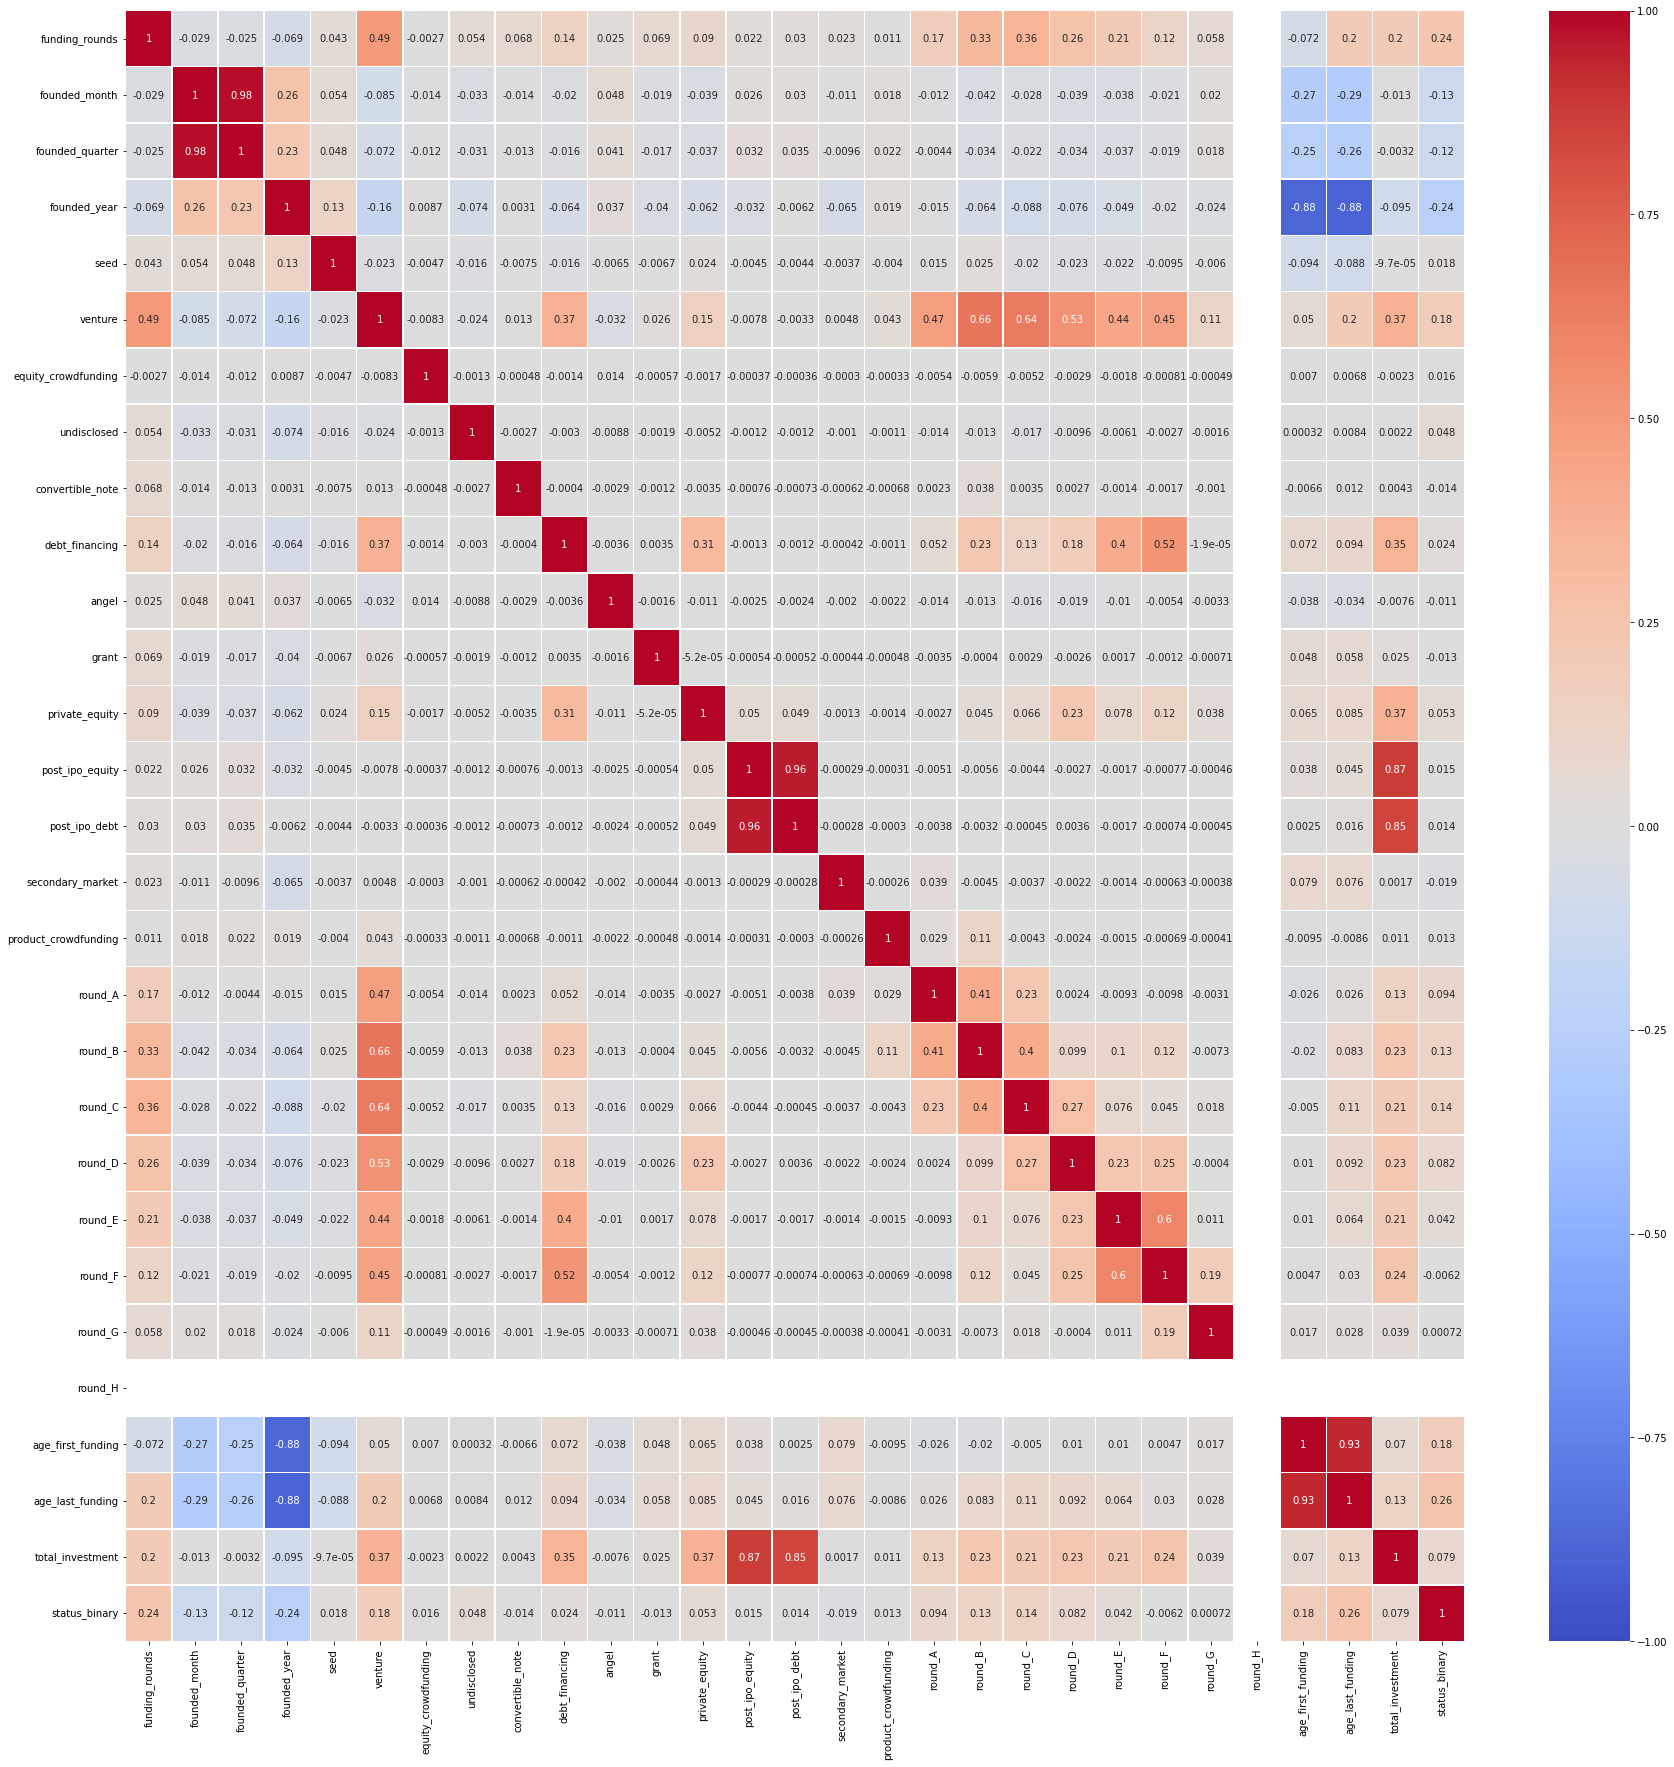

In [ ]:
plt.figure(figsize=(30,30))
startup_heat = df.corr()

startup_heat= sns.heatmap(startup_heat, annot=True,linewidth = 0.5, cmap='coolwarm', vmin=-1, vmax=1)

bottom, top = startup_heat.get_ylim()
startup_heat.set_ylim(bottom, top)

plt.show()

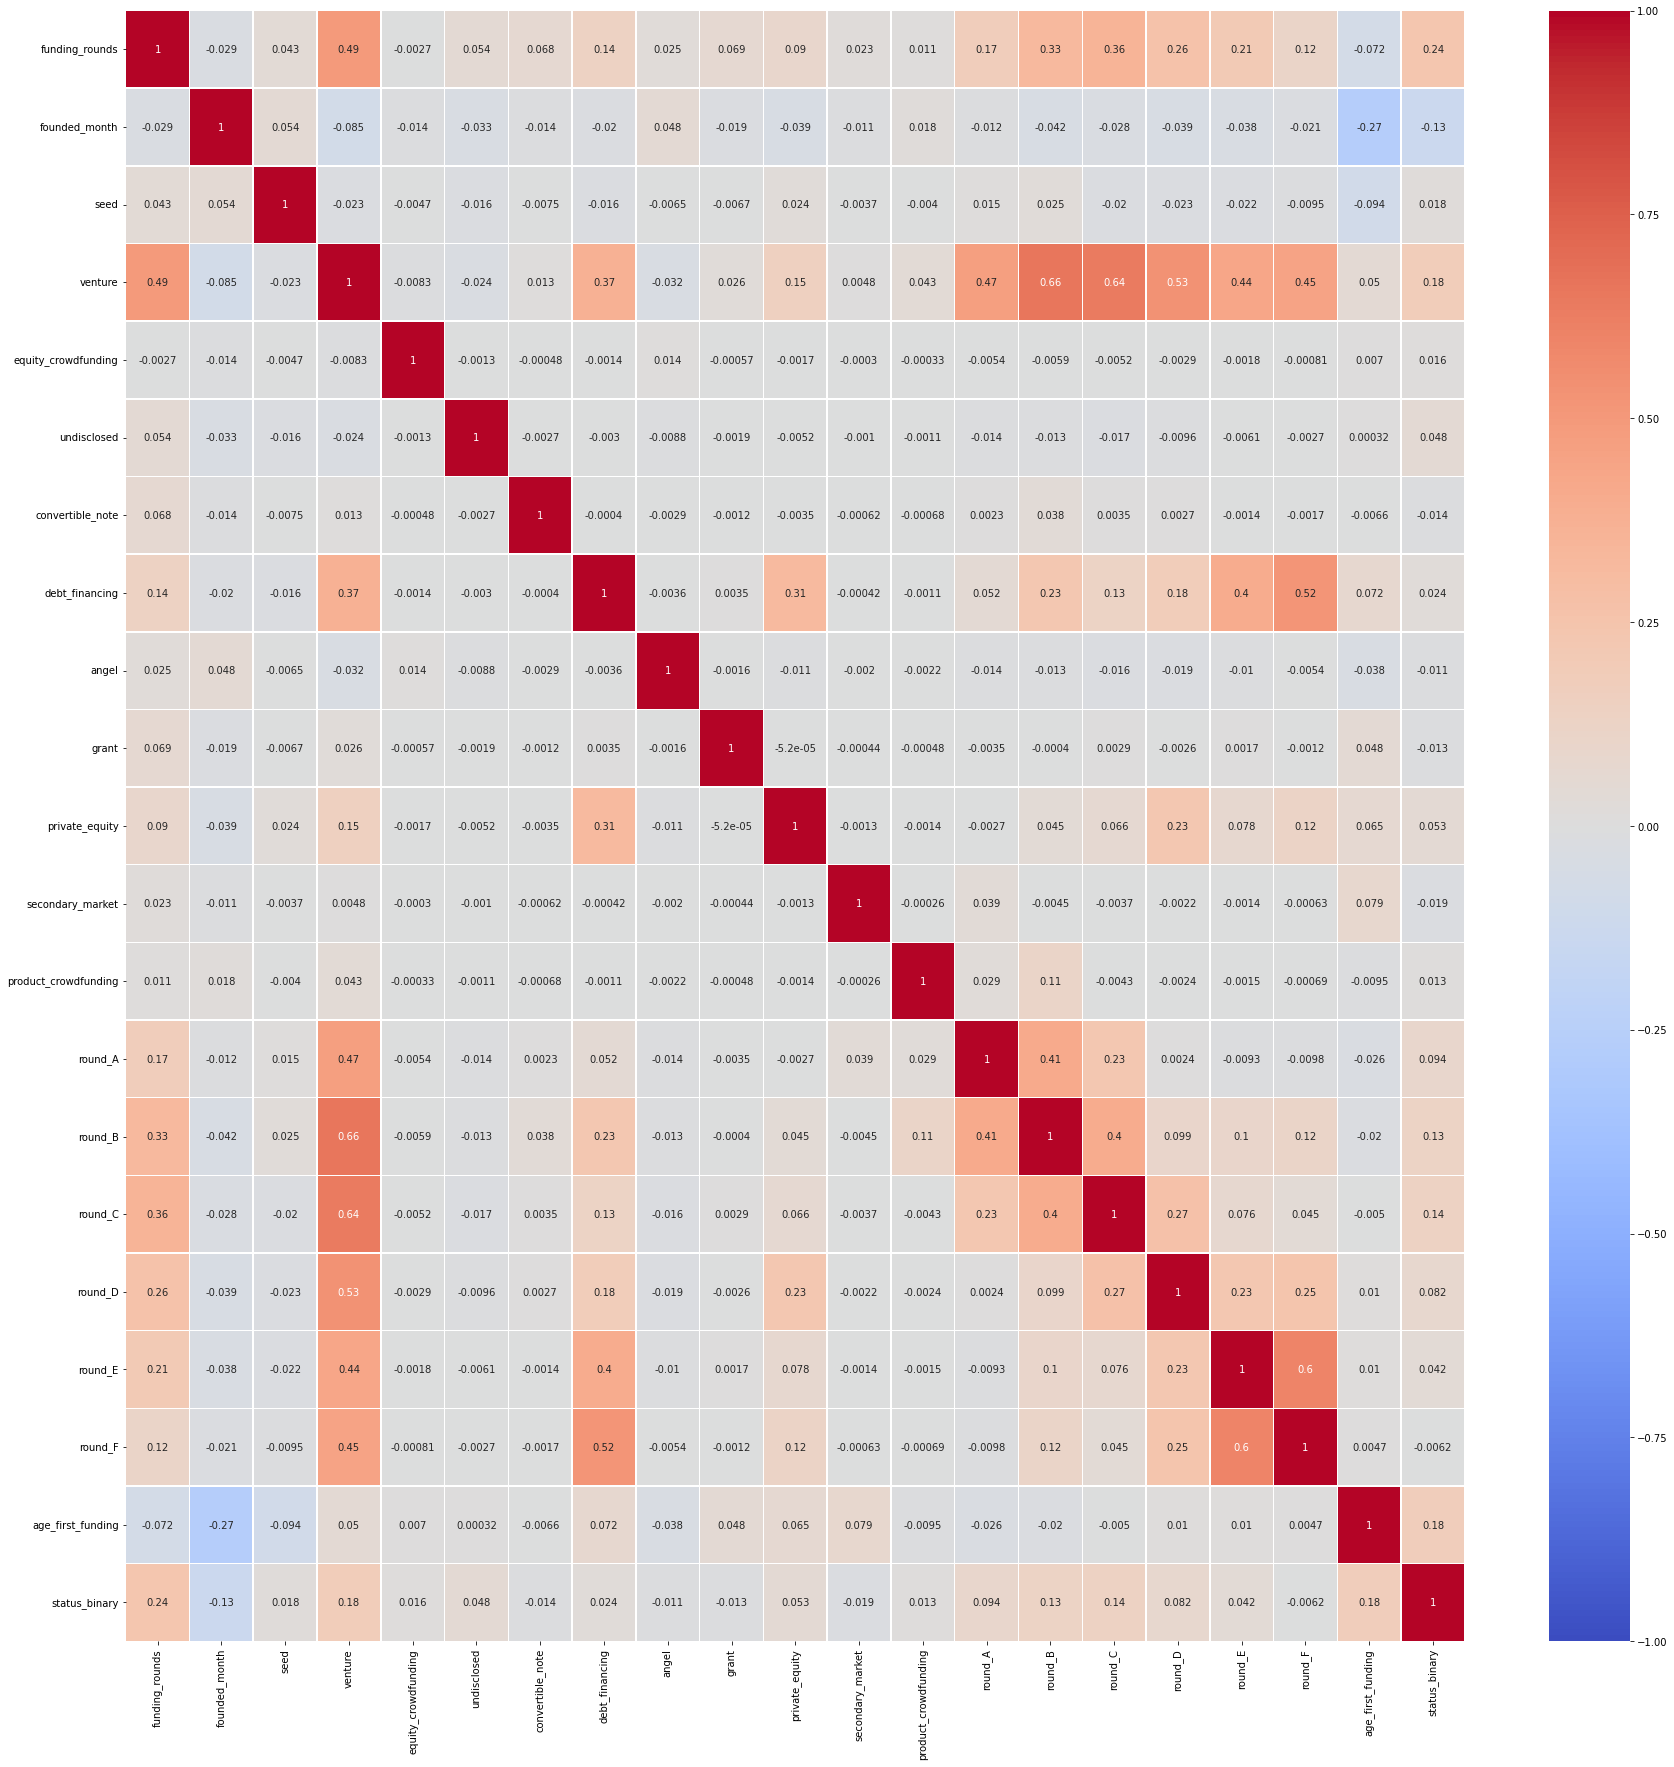

In [ ]:
#Hence, the correlation of a few different attributes are blank
#we are further excluding these from the model
df = df.drop(
    [
     'post_ipo_equity'
     ,'post_ipo_debt'
     ,'round_G'
     ,'round_H'
     ,'founded_year'
     ,'founded_quarter'
     ,'total_investment'
     ,'age_last_funding'
     ], axis = 1)
plt.figure(figsize=(30,30))
startup_heat = df.corr()

startup_heat= sns.heatmap(startup_heat, annot=True,linewidth = 0.5, cmap='coolwarm', vmin=-1, vmax=1)

bottom, top = startup_heat.get_ylim()
startup_heat.set_ylim(bottom, top)

plt.show()

In [ ]:
modelling_df = df
X = pd.get_dummies(modelling_df.drop(['status_binary'],axis = 1))
y = modelling_df['status_binary']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 10)

In [ ]:
n = 10
while n <= 200:
  model = RandomForestClassifier(n_estimators=n)
  model.fit(X_train, y_train)
  print('{} - train score: {:.3f} | test score: {:.3f}'.format(n,model.score(X_train,y_train),model.score(X_test,y_test)))
  n = n+10

10 - train score: 0.985 | test score: 0.740
20 - train score: 0.997 | test score: 0.734
30 - train score: 0.998 | test score: 0.736
40 - train score: 0.999 | test score: 0.740
50 - train score: 1.000 | test score: 0.758
60 - train score: 1.000 | test score: 0.758
70 - train score: 1.000 | test score: 0.746
80 - train score: 1.000 | test score: 0.750
90 - train score: 1.000 | test score: 0.748
100 - train score: 1.000 | test score: 0.742
110 - train score: 1.000 | test score: 0.745
120 - train score: 1.000 | test score: 0.742
130 - train score: 1.000 | test score: 0.738
140 - train score: 1.000 | test score: 0.746
150 - train score: 1.000 | test score: 0.735
160 - train score: 1.000 | test score: 0.750
170 - train score: 1.000 | test score: 0.747
180 - train score: 1.000 | test score: 0.743
190 - train score: 1.000 | test score: 0.746
200 - train score: 1.000 | test score: 0.747


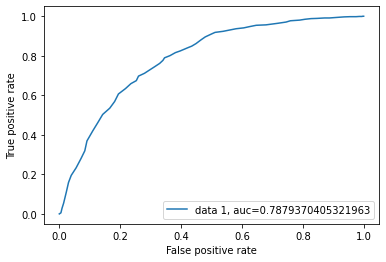

In [ ]:
model = RandomForestClassifier(n_estimators=60) 
model.fit(X_train, y_train)

#ROC CURVE - Plotting the true positives against the false positives and an AUC score
y_pred_proba_rf = model.predict_proba(X_test) [:,1]
y_predrf = model.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_rf)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rf)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predrf)

array([[323, 238],
       [145, 773]])

In [ ]:
y_pred_proba_rf

array([0.31666667, 0.85      , 0.88333333, ..., 0.85      , 0.7       ,
       0.95      ])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predrf, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       561
           1       0.76      0.84      0.80       918

    accuracy                           0.74      1479
   macro avg       0.73      0.71      0.71      1479
weighted avg       0.74      0.74      0.74      1479



In [ ]:
# result = permutation_importance(model, X_train, y_train, n_repeats=10,random_state=0)
# fimp = pd.Series(result.importances_mean,index=X_train.columns.values).sort_values(ascending=False)
# fimp

In [ ]:
# rfecv = RFECV(estimator=model, step=1,cv=StratifiedKFold(10),scoring='accuracy')
# rfecv.fit(X_train,y_train)

# plt.figure(figsize=(9,5))
# plt.plot(range(1, len(rfecv.grid_scores_)+1),rfecv.grid_scores_,linewidth=3)
# plt.title('The correlation between the number of attributes and the accuracy of the model')
# plt.show()

In [ ]:
# X_train.columns[np.where(rfecv.support_ == False)[0]]

MLP CLASSIFIER


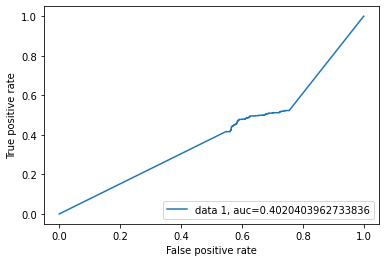

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
# X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
#                                                     random_state=1)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
# model = RandomForestClassifier(n_estimators=70) 
# model.fit(X_train, y_train)

#ROC CURVE - Plotting the true positives against the false positives and an AUC score
y_pref_proba_mlp = clf.predict_proba(X_test)[:,1]
y_predmlp = clf.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pref_proba_mlp)
auc = metrics.roc_auc_score(y_test, y_pref_proba_mlp)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
print(classification_report(y_test, y_predmlp, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.32      0.43      0.37       561
           1       0.56      0.45      0.50       918

    accuracy                           0.44      1479
   macro avg       0.44      0.44      0.43      1479
weighted avg       0.47      0.44      0.45      1479



Logistic regression

In [ ]:
logreg = LogisticRegressionCV(max_iter=10000, scoring='roc_auc')
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

The training model accuracy: 0.7288
The test model accuracy: 0.7428


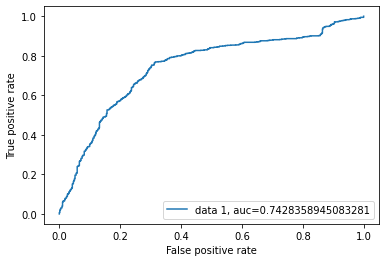

In [ ]:
#ROC CURVE - Plotting the true positives against the false positives and an AUC score
y_pred_proba_lr = logreg.predict_proba(X_test) [:,1]
y_predlr = logreg.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_lr)
auc = metrics.roc_auc_score(y_test, y_pred_proba_lr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predlr)

array([[ 50, 511],
       [ 26, 892]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predlr, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.66      0.09      0.16       561
           1       0.64      0.97      0.77       918

    accuracy                           0.64      1479
   macro avg       0.65      0.53      0.46      1479
weighted avg       0.64      0.64      0.54      1479



In [ ]:
xgboost

In [ ]:
import xgboost as xgb
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train, y_train)

XGBClassifier()

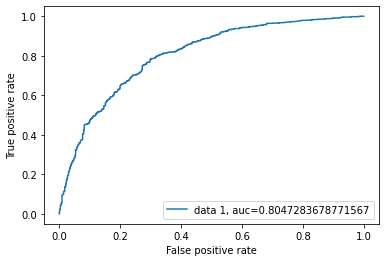

In [ ]:
y_predxgb = xgb_cl.predict(X_test)
y_pred_proba_xgb = xgb_cl.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_xgb)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predxgb)

array([[334, 227],
       [147, 771]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predxgb, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64       561
           1       0.77      0.84      0.80       918

    accuracy                           0.75      1479
   macro avg       0.73      0.72      0.72      1479
weighted avg       0.74      0.75      0.74      1479



In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [ ]:
y_predknn = knn_model.predict(X_test)
# y_pred_proba_knn = knn_model.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba_knn)
# auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.legend(loc=4)
# plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predknn)

ValueError: ignored

In [ ]:
y_test

28082    0
17189    1
16552    0
23059    0
12436    1
        ..
19321    1
16220    1
27012    1
27050    1
9511     1
Name: status_binary, Length: 1479, dtype: int64

In [ ]:
temp= []
for x in y_predknn:
  if x <= 0.5:
    temp.append(0)
  else:
    temp.append(1)  
y_predknn = temp.copy()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predknn, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       561
           1       0.76      0.77      0.77       918

    accuracy                           0.71      1479
   macro avg       0.69      0.69      0.69      1479
weighted avg       0.71      0.71      0.71      1479



In [ ]:
import statistics as st
final_pred = np.array([])
for i in range(0,len(X_test)):
  final_pred=np.append(final_pred, st.mode([ y_predrf[i], y_predlr[i], y_predmlp[i],y_predxgb[i],y_predknn[i]]))
print(classification_report(y_test, final_pred, target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.73      0.52      0.60       561
           1       0.75      0.88      0.81       918

    accuracy                           0.74      1479
   macro avg       0.74      0.70      0.71      1479
weighted avg       0.74      0.74      0.73      1479



If you would like play with using a GPU or TPU for inference, please see our advanced demo notebook here https://colab.research.google.com/github/Santosh-Gupta/NaturalLanguageRecommendations/blob/master/notebooks/inference/build_index_and_search.ipynb

### NOTE: This colab notebook automatically records queries submitted (anonymously), which will be used to optimize the next iterations of our model. If you wish not to automatically send queries, use this notebook instead https://colab.research.google.com/drive/1Es_peeshcFsReqFEVr12GIiGPKD0KnKY

In [ ]:
#@title Download and load model, embeddings, and data, will take a several minutes. Double click on this to pop open the hood and checkout the code.

!gdown --id "10LV9QbZOkUyOzR4nh8hxesoKJhpmvpM9"   # citation vectors
# !gdown --id "1-8gmT9cQpOUoZ_HzEaT9Xz6qfeVooAFn"
!gdown --id "1-23aNm7j0bnycvyd_OaQfofVYPTewgOI"   # abstract vectors
!gdown --id "1NyUQwgUNj9bFsiCnZ2TfKmWn5r-Y6wav"   # TitlesIdAbstractsEmbedIds
!gdown --id "1wIRsAApaE2L7E1fjnDOSSVBG1fY-LT9i" # Model
!wget 'https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/huggingface_pytorch/scibert_scivocab_uncased.tar'
!tar -xvf 'scibert_scivocab_uncased.tar'

import zipfile
with zipfile.ZipFile('tfworld.zip', 'r') as zip_ref:
    zip_ref.extractall('')

!pip install transformers --quiet

%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
from time import time
from tqdm import tqdm_notebook as tqdm
from transformers import BertTokenizer
import pandas as pd
from pprint import pprint

print('TensorFlow:', tf.__version__)

!gdown --id "1owiHXcDyTYecOq0Y27bOk0s4jgxmukTs"
!pip install --upgrade --quiet gspread
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://www.googleapis.com/auth/spreadsheets']
credentials = ServiceAccountCredentials.from_json_keyfile_name('worksheet1.worksheet2.worksheet3.json', scope)
gc = gspread.authorize(credentials)
worksheet1 = gc.open_by_key('1qlIZAAK3ZYTb20KeOr9f-TAxYz7yQnvHUsdGP9Iakrc').sheet1
worksheet2 = gc.open_by_key('1AU37NTxsafd9GNhum2yR3iCux9nT9GAN5Bn4HaWcyU4').sheet1
worksheet3 = gc.open_by_key('1Vaxn8rWz0CufCeDF_Ip9lzErZjK3AUA3g02fYMBe5P4').sheet1

print('Loading Embeddings')
citations_embeddings = np.load('CitationSimilarityVectors106Epochs.npy')
abstract_embeddings = np.load('AbstractSimVectors.npy')
assert citations_embeddings.shape == abstract_embeddings.shape

normalizedC = tf.nn.l2_normalize(citations_embeddings, axis=1)
normalizedA = tf.nn.l2_normalize(abstract_embeddings, axis=1) 

print('Loading Model')
model = tf.saved_model.load('tfworld/inference_model/')
print('laoding Tokenizer')
tokenizer = BertTokenizer(vocab_file='scibert_scivocab_uncased/vocab.txt')

print('Loading Semantic Scholar CS data, almost done . . .')
df = pd.read_json('/content/TitlesIdsAbstractsEmbedIdsCOMPLETE_12-30-19.json.gzip', compression = 'gzip')
embed2Title = pd.Series(df['title'].values,index=df['EmbeddingID']).to_dict()
embed2Abstract = pd.Series(df['paperAbstract'].values,index=df['EmbeddingID']).to_dict()
embed2Paper = pd.Series(df['id'].values,index=df['EmbeddingID']).to_dict()

import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

Use cell below to search for papers. Our model was trained on using full abstracts using the 'query', so the model performs better with longer queries, but the model works surprisingly well with short queries as well. Give it a try.

Our model was trained to use a citation emedding as a label, but we found out running similarity on our abstract embeddings results in surprisingly robust results as well, so we included both. The first half of the results are from the citation embeddings, the second half are from the abstract embeddings. 

In [ ]:
query = "Vector representation of text for information retrieval. Document embeddings for search. Vector representation of query. Embedding representation of queries. " #@param {type:"string"}

top_k_results = 50 #@param {type:"integer"}

if top_k_results%2 == 0:
    halfA = halfC = int(top_k_results/2)
else:
    halfC = int(top_k_results/2) + 1
    halfA = int(top_k_results/2) 

abstract_encoded = tokenizer.encode(query, max_length=512, pad_to_max_length=True)
abstract_encoded = tf.constant(abstract_encoded, dtype=tf.int32)[None, :]
print('\nQuery : ')
pprint(query)

s = time()
bert_output = model(abstract_encoded)
xq = tf.nn.l2_normalize(bert_output, axis=1)
prediction_time = time() - s

simNumpyC = np.matmul(normalizedC, tf.transpose(xq))
simNumpyCTopK = (-simNumpyC[:,0]).argsort()[:halfC]
simNumpyC_oTopK = -np.sort(-simNumpyC[:,0])[:halfC]
allCit = np.vstack((simNumpyCTopK , simNumpyC_oTopK) )
del simNumpyC

simNumpyA = np.matmul(normalizedA, tf.transpose(xq))
simNumpyATopK = (-simNumpyA[:,0]).argsort()[:halfA]
simNumpyA_oTopK = -np.sort(-simNumpyA[:,0])[:halfA]
allAbs = np.vstack((simNumpyATopK , simNumpyA_oTopK) )
del simNumpyA

allResults = np.concatenate((allAbs, allCit), axis = 1)

print('\n')

print('------ Nearest papers  -----------------------------------------------------------')
print('\n')

for embed in allResults[0]:
    print('---------------')
    print('-------')
    print('---')
    title = embed2Title[int(embed)]
    abstractR = embed2Abstract[int(embed)]
    paperId = embed2Paper[int(embed)]
    print('Title: ', title)
    print('\nAbstract : ')
    pprint(abstractR)
    # print('\n')
    print('\nLink: https://www.semanticscholar.org/paper/'+paperId)
    print('---')
    print('-------')

blockPrint()
values_list = worksheet1.col_values(3)
worksheet1.update_cell(len(values_list)+1, 3, query)
enablePrint()



## If you have any additional feedback about a query, or just feedback in general, we would very much appreciate it. The feedback will help in the qualitative analysis of our models

In [ ]:
#@title Feedback about a particular query

%%capture

query = "Vector representation of text for information retrieval. Document embeddings for search. Vector representation of query. Embedding representation of queries. " #@param {type:"string"}

feedback = "First result didn't seem to say anything about negative sampling" #@param {type:"string"}

blockPrint()
values_list = worksheet2.col_values(3)
values_list2 = worksheet2.col_values(4)
rowV = max(len(values_list) , len(values_list2) )
worksheet2.update_cell(rowV+1, 3, query)
worksheet2.update_cell(rowV+1, 4, feedback)
enablePrint()

print('Submitted')
print('Query recorded, ', query)
print('Feedback recorded, ', feedback)

In [ ]:
#@title Feedback

%%capture

feedback = "UI could use some work" #@param {type:"string"}

blockPrint()
values_list = worksheet3.col_values(3)
values_list2 = worksheet3.col_values(4)
rowV = max(len(values_list) , len(values_list2) )
worksheet3.update_cell(rowV+1, 3, feedback)
enablePrint()

print('Submitted')
print('Feedback recorded, ', feedback)